In [16]:
from typing import Annotated, Literal, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

llm = ChatOllama(model="deepseek-r1:1.5b", temperature=0.5)

In [17]:
from langchain_core.prompts import ChatPromptTemplate

system = "You are a helpful assistant."
human = "{input}"
prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", human)])

chain = prompt | llm
response = chain.invoke({"input": "Where is Taj Mahal located?"})
response.content

'The Taj Mahal is located in Agra, India, specifically within the Agraabad district. It is a UNESCO World Heritage Site, known for its architectural and cultural significance.'

In [18]:


class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "Logical"] = Field(
        ...,
        description="Classify if the message requires an emotional or logical response"
    )


class State(TypedDict):
    messages: Annotated[List, add_messages]
    message_type: str | None


def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - "emotional: if user sounds sad, looking for emotional or mental support, dealing with feelings or personal problems,
            - 'logical': If the user asks for facts, information, typical analysis, or practical response
            """

        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}


# if no classification, use default as logical
def router(state: State):
    message_type = state.get('message_type', 'logical')
    if message_type == "emotional":
        return {"next": "emotional"}
    return {"next": "logical"}


def emotionsl_agent(state: State):
    last_message = state["messages"][-1]
    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                    Show empathy, validate their feelings, and help them process their emotions.
                    Ask thoughtful questions to help them explore their feelings more deeply.
                    Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


def logical_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

In [19]:
graph_builder = StateGraph(State)
graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("emotional", emotionsl_agent)
graph_builder.add_node("logical", logical_agent)


graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {"emotional": "emotional", "logical": "logical"}
)

graph_builder.add_edge("emotional", END)
graph_builder.add_edge("logical", END)

graph = graph_builder.compile()

In [ ]:
%pip install IPython

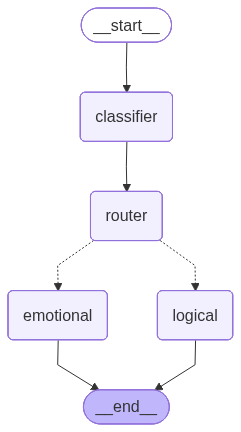

In [12]:
from IPython.display import Image, display # type: ignore

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# def run_chatbot(prompt):
#     state = {"messages": [], "message_type": None}

#     while True:
#         user_input = prompt
#         if user_input == "exit":
#             print("Bye")
#             break

#         state["messages"] = state.get("messages", []) + [
#             {"role": "user", "content": user_input}
#         ]

#         state = graph.invoke(state)

#         if state.get("messages") and len(state["messages"]) > 0:
#             last_message = state["messages"][-1]
#             print(f"Assistant: {last_message.content}")

In [20]:
def run_chatbot(prompt):

    state = {"messages": [], "message_type": None}

    state["messages"] = state.get("messages", []) + [
        {"role": "user", "content": prompt}
    ]

    state = graph.invoke(state)

    if state.get("messages") and len(state["messages"]) > 0:
        last_message = state["messages"][-1]
        print(f"Assistant: {last_message.content}")

In [21]:
run_chatbot("I want facts about global warming")

Assistant: The global warming issue is multifaceted, involving both natural and human factors. Here's a structured summary:

1. **Primary Greenhouse Gas**: Carbon dioxide (CO2) is the primary greenhouse gas responsible for global warming due to its role as a potent gas that traps heat in the atmosphere.

2. **Human Activities**: Human activities, such as burning fossil fuels and industrial processes, are significant contributors to CO2 emissions. These activities increase atmospheric CO2 levels, which trap more heat, leading to global warming.

3. **Natural Factors**: While human activities play a dominant role, natural factors also contribute. Examples include volcanic eruptions (e.g., sulfur hexafluoride release) and biological processes like soil organic carbon storage.

4. **Gas Trapping Efficiency**: CO2 is highly efficient at trapping heat compared to other gases like nitrous oxide (NOx). However, NOx is trickier due to its reactivity with other substances in the atmosphere.

5. 